In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import math
import pandas as pd
from gplearn.tests.test_genetic import *
from gplearn._program import _Program
from gplearn.genetic import _all_func_dictionary, _fitness_map, _extra_fitness_map
from gplearn.extra_fitness import *
from gplearn.extra_fitness import _bad_fitness_val
import matplotlib.pyplot as plt

In [3]:
df = pd.read_parquet('/home/pennymax/proj/MFM/CrossSection/v1_basic/results/basic_2023-11-22_22:15:18/fct_man_ta_proc.parquet')
# df = df.query('"2020-09-01 00:00:00+00:00" <= time < "2023-12-01 00:00:00+00:00"')
# df = df.query('"2023-01-01 00:00:00+00:00" <= time < "2024-01-01 00:00:00+00:00"')
df = df.query('"2021-12-01 00:00:00+00:00" <= time < "2024-01-01 00:00:00+00:00"')
# df = df.query('"2021-12-01 00:00:00+00:00" <= time < "2024-01-01 00:00:00+00:00"')
# df = df.query('"2020-09-01 00:00:00+00:00" <= time < "2024-01-01 00:00:00+00:00"')
df

AR_26  BCKRET1_ALMA_10_6.0_0.85  \
time                      symbol                                             
2021-12-01 00:00:00+00:00 1000SHIBUSDT  1.014055                  0.044819   
                          1000XECUSDT  -0.669586                 -0.100752   
                          1INCHUSDT    -1.067605                 -0.426904   
                          AAVEUSDT     -0.386987                  0.273056   
                          ADAUSDT      -1.235662                  0.275985   
...                                          ...                       ...   
2023-12-31 16:00:00+00:00 YGGUSDT       0.257268                 -0.103932   
                          ZECUSDT      -1.408951                 -2.636440   
                          ZENUSDT      -0.826190                 -3.165469   
                          ZILUSDT      -1.044529                 -0.341974   
                          ZRXUSDT      -0.450815                  0.204886   

                                        BCKRET1_ANGLEd_1  BCKRET1_APO_12_26  \
time                      symbol                                              
2021-12-01 00:00:00+00:00 1000SHIBUSDT         -0.638462           1.060945   
                          1000XECUSDT          -0.276250           0.183604   
                          1INCHUSDT             0.416600          -0.059003   
                          AAVEUSDT              0.395956           0.729442   
                          ADAUSDT               0.550755           0.589924   
...                                                  ...                ...   
2023-12-31 16:00:00+00:00 YGGUSDT               0.864582          -0.758928   
                          ZECUSDT              -0.891221          -0.528491   
                          ZENUSDT              -0.323927          -1.497199   
                          ZILUSDT              -0.249491          -0.132838   
                          ZRXUSDT               0.580030           1.204474   

                                        BCKRET1_BIAS_SMA_26  BCKRET1_CFO_9  \
time                      symbol                                             
2021-12-01 00:00:00+00:00 1000SHIBUSDT            -0.124325       0.109029   
                          1000XECUSDT             -0.078235       0.018214   
                          1INCHUSDT               -0.098711       0.052219   
                          AAVEUSDT                 0.217111      -0.154076   
                          ADAUSDT                 -0.090385       0.012263   
...                                                     ...            ...   
2023-12-31 16:00:00+00:00 YGGUSDT                  0.061510            NaN   
                          ZECUSDT                  0.275014       0.144802   
                          ZENUSDT                  0.348065       0.118468   
                          ZILUSDT                -11.075531       0.187631   
                          ZRXUSDT                  0.144707      -0.246017   

                                        BCKRET1_CG_10  BCKRET1_CMO_14  \
time                      symbol                                        
2021-12-01 00:00:00+00:00 1000SHIBUSDT       0.139449       -1.784442   
                          1000XECUSDT        0.196364       -0.120097   
                          1INCHUSDT         -0.203898        0.328285   
                          AAVEUSDT           0.220337        0.499613   
                          ADAUSDT            0.196679        0.536447   
...                                               ...             ...   
2023-12-31 16:00:00+00:00 YGGUSDT            0.113462        0.796809   
                          ZECUSDT            0.055890       -1.707109   
                          ZENUSDT            0.052056       -0.499113   
                          ZILUSDT            0.060675       -0.450030   
                          ZRXUSDT            0.080373        1.195934   

                                   

In [4]:
df.sort_index().reset_index()['time'].unique()

<DatetimeArray>
['2021-12-01 00:00:00+00:00', '2021-12-01 08:00:00+00:00',
 '2021-12-01 16:00:00+00:00', '2021-12-02 00:00:00+00:00',
 '2021-12-02 08:00:00+00:00', '2021-12-02 16:00:00+00:00',
 '2021-12-03 00:00:00+00:00', '2021-12-03 08:00:00+00:00',
 '2021-12-03 16:00:00+00:00', '2021-12-04 00:00:00+00:00',
 ...
 '2023-12-28 16:00:00+00:00', '2023-12-29 00:00:00+00:00',
 '2023-12-29 08:00:00+00:00', '2023-12-29 16:00:00+00:00',
 '2023-12-30 00:00:00+00:00', '2023-12-30 08:00:00+00:00',
 '2023-12-30 16:00:00+00:00', '2023-12-31 00:00:00+00:00',
 '2023-12-31 08:00:00+00:00', '2023-12-31 16:00:00+00:00']
Length: 2283, dtype: datetime64[ns, UTC]

In [21]:
# def _get_X_y(df):
#     df = df.sort_index()
#     display(df)
#     dfX = df.drop(columns=[col for col in df.columns if col.startswith('fwdret')])
#     feature_names = list(dfX.columns)
#     dfX = dfX.unstack()
#     display(dfX)
#     X = dfX.values.reshape(len(dfX), len(feature_names), -1)

#     y = df[['fwdret1']].unstack().to_numpy()
#     display(df[['fwdret1']].unstack())
#     print(X.shape, y.shape, len(feature_names))
#     return X, y, feature_names

## X: time x feature x symbol
## y: time x forward return 1
def _get_X_y(df):
    df = df.sort_index()
    dfX = df.drop(columns=[col for col in df.columns if col.startswith('fwdret')])
    feature_names = list(dfX.columns)
    dfX = dfX.unstack().sort_index()
    X = dfX.values.reshape(len(dfX), len(feature_names), -1)

    y = df[['fwdret1']].unstack().sort_index().to_numpy()
    return X, y, feature_names

def convert_expression_to_gp_program(expression: str, function_set: dict, feature_names: list) -> _Program:
    ## convert expression to list function obj and feature index
    tokens = re.findall(r'[\w.]+|\(|\)|,', expression)
    tokens = [t for t in tokens if t not in ['(', ')', ',']]
    # print(tokens)
    program = []
    for token in tokens:
        if token in function_set:
            program.append(function_set[token])
        elif token in feature_names:
            program.append(feature_names.index(token))
        elif token.isdigit():
            program.append(int(token))
        elif token.replace('.', '', 1).isdigit():
            program.append(float(token))
        else:
            print(f'!! unknown token found! {token}')
            return None
    # print(program)

    ## get arity dict
    arities = {}
    for function in function_set.values():
        arity = function.arity
        arities[arity] = arities.get(arity, [])
        arities[arity].append(function)

    ## construct _Program obj
    params = {
            'function_set': function_set,
            'arities': arities,
            'n_features': len(feature_names),
            'feature_names': feature_names,
            'init_depth': (2, 6),
            ## must inputs
            'init_method': 'half and half',
            'const_range': (-1.0, 1.0),
            'metric': 'mean absolute error',
            'p_point_replace': 0.05,
            'parsimony_coefficient': 0.1,
            'random_state': check_random_state(415),
            }
    gp = _Program(program=program, **params)
    return gp

In [22]:
X, y, feature_names = _get_X_y(df)

In [23]:
exp = 'sub(mul(BCKRET1_MOM_5, SPOTVOLUME_TSIs_13_25_13), premIdx_close)'
exp = 'sub(SPOT_COPC_11_14_10, ts_correlation_20(SPOTTAKERBUYQUOVOL_PPOh_12_26_9, TRDCNT_TSI_13_25_13))'
exp = 'inv(rank(TZS60_spot_Close))'
exp = 'ts_mean_20(inv(inv(TZS60_spot_Close)))'
exp = 'min(NETBUYQUO1_FWMA_10, ts_min_10(TZS60_SPOT_HLC3))'
# exp = 'neg(add(premIdx_close, max(TZS60_VOLUME_PPO_12_26_9, PREMCLOSE_MACDs_12_26_9)))'
exp = 'sub(min(ts_mean_10(bckret1), netbuyquo3), max(ts_min_3(QuoVol), premIdx_close))'
exp = 'netbuyquo3'
# exp = 'sub(netbuyquo3, premIdx_close)'
# exp = 'sub(ts_min_10(TZS60_spot_Close), premIdx_close)'
# exp = 'min(NETBUYQUO1_JMA_7_0, ts_min_10(SMI_5_20_5))'
# exp = 'min(NETBUYQUO5_DEMA_10, ts_min_10(TZS60_SPOT_HL2))'
# exp = 'max(min(netbuyquo3, bckret3), netbuyquo5)'
# exp = 'add(sub(min(ts_mean_10(bckret1), netbuyquo3), max(ts_min_3(QuoVol), premIdx_close)), min(NETBUYQUO5_DEMA_10, ts_min_10(TZS60_SPOT_HL2)))'
# exp = 'add(sub(min(ts_mean_10(bckret1), netbuyquo3), max(ts_min_3(QuoVol), premIdx_close)), max(min(netbuyquo3, bckret3), netbuyquo5))'
# exp = 'delay_1(ts_std_60(ts_kama_60(ts_entropy_60(PREMCLOSE_QQE_14_5_4.236))))'
# exp = 'ts_kama_10(PREMCLOSE_PSL_12)'
# exp = 'add(add(NETBUYQUO1_FWMA_10, min(TZS60_SPOT_SMA_10, TAKERBUYQUOVOL_KAMA_10_2_30)), add(sub(min(ts_mean_10(bckret1), netbuyquo3), max(ts_min_3(QuoVol), premIdx_close)), min(NETBUYQUO5_DEMA_10, ts_min_10(TZS60_SPOT_HL2))))'
# exp = 'ts_mean_5(ts_quantile25_10(SMI_5_20_5))'
# exp = 'if_then_else(STOCHk_14_3_3, ts_min_10(TZS60_spot_Low), VOLUME_ROC_1)'
# exp = 'add(sub(min(ts_mean_10(bckret1), netbuyquo3), max(ts_min_3(QuoVol), premIdx_close)), if_then_else(STOCHk_14_3_3, ts_min_10(TZS60_spot_Low), VOLUME_ROC_1))'
# exp = 'min(NETBUYQUO1_EMA_10, ts_min_10(TZS60_HL2))'
# exp = 'min(NETBUYQUO1_EMA_10, ts_quantile25_10(TZS60_HMA_10))'
# exp = 'min(ts_min_10(TZS60_SPOT_OHLC4), ts_min_5(netbuyquo3))'
# exp = 'min(NETBUYQUO3_EMA_10, ts_min_10(TZS60_SPOT_JMA_7_0))'
# exp = 'add(netbuyquo3, netbuyquo1)'
# exp = 'sub(ts_min_5(TZS60_SPOT_DEMA_10), TZS60_SPOTTAKERBUYVOL_PWMA_10)'
# exp = 'add(sub(ts_min_5(TZS60_SPOT_DEMA_10), TZS60_SPOTTAKERBUYVOL_PWMA_10), netbuyquo3)'
# exp = 'ts_delta1pct_mean_60(ts_mean_60(sub(ts_argmaxmin_60(FUND_CTI_12), ts_quantile25_40(ts_wma_20(NETBUYQUO1_FWMA_10)))))'
# exp = 'sub(ts_regr_beta_60(BCKRET1_TSIs_13_25_13, TZS60_BULLP_13), TZS60_SPOTTRDCNT_EMA_10)'
# exp = 'sub(ts_quantile25_10(TZS60_SPOT_MACDh_12_26_9), SPOTTAKERBUYVOL_KSTs_9)'
# exp = 'add(NETBUYQUO1_HMA_10, sub(spotum_quo_rt5, SPOTTAKERBUYVOL_KST_10_15_20_30_10_10_10_15))'
# exp = 'ts_min_20(mul(SPOTTAKERBUYQUOVOL_BIAS_SMA_26, ts_min_20(TZS60_SPOT_MOM_3)))'
exp = 'sub(ts_min_60(TZS60_SPOT_MACDh_12_26_9), TZS60_SPOTTAKERBUYVOL_SWMA_10)'
exp = 'ts_quantile75_20(ts_wma_60(ts_autocorr_60_3(ts_regr_beta_3(ts_ema_5(AR_26), ts_ema_40(netbuyquo3)))))'
# exp = 'ts_dema_10(ts_wma_60(ts_autocorr_60_3(ts_regr_beta_3(ts_ema_5(AR_26), ts_ema_40(netbuyquo3)))))'

print(f'ori expression: {exp}')
feature_names = df.columns.to_list()
gp = convert_expression_to_gp_program(exp, _all_func_dictionary, feature_names)
print(f'_Program print: {gp}')

y_pred = gp.execute_3D(X)
display(pd.DataFrame(y_pred).describe())

metric_values = []
for metric_name, metric_func in _extra_fitness_map.items():
    metric_val = metric_func(y, y_pred, np.ones(X.shape[0]))
    metric_values.append(metric_val)
metric_df = pd.DataFrame(metric_values, index = _extra_fitness_map.keys())
display(metric_df.round(3))

ori expression: ts_quantile75_20(ts_wma_60(ts_autocorr_60_3(ts_regr_beta_3(ts_ema_5(AR_26), ts_ema_40(netbuyquo3)))))
_Program print: ts_quantile75_20(ts_wma_60(ts_autocorr_60_3(ts_regr_beta_3(ts_ema_5(AR_26), ts_ema_40(netbuyquo3)))))


,0,1,2,3,4,5,6,7,8,9,...,245,246,247,248,249,250,251,252,253,254
count,360.000000,0.0,0.0,12.000000,304.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,0.031901,NaN,NaN,-0.066930,0.020083,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.102228,NaN,NaN,0.002590,0.048873,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-0.177827,NaN,NaN,-0.070325,-0.069369,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,-0.042683,NaN,NaN,-0.068852,-0.037237,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.033499,NaN,NaN,-0.067306,0.040161,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,0.112564,NaN,NaN,-0.065496,0.055566,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,0.213161,NaN,NaN,-0.061998,0.091114,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,0
rank_ic,0.019
rank_icir,0.049
quantile35_longshort_total_return_cumprod_with_fee,48.108
quantile35_longshort_total_return_cumsum_with_fee,4.359
quantile35_longshort_cagr_cumprod_with_fee,6.313
quantile35_longshort_cagr_cumsum_with_fee,2.228
quantile35_longshort_cagr_cumprod,6.552
quantile35_longshort_cagr_cumsum,2.259
quantile35_longshort_sharpe_fine_cumprod_with_fee,8.561
quantile35_longshort_sharpe_fine_cumsum_with_fee,3.022


In [24]:
display(pd.DataFrame(y_pred).dropna(how='all', axis=0))

,0,1,2,3,4,5,6,7,8,9,...,245,246,247,248,249,250,251,252,253,254
140,-0.002192,NaN,NaN,NaN,0.022382,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,-0.003052,NaN,NaN,NaN,0.026264,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,-0.003965,NaN,NaN,NaN,0.029995,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,-0.004838,NaN,NaN,NaN,0.033464,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144,-0.005704,NaN,NaN,NaN,0.036841,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


count    2142.000000
mean        0.002035
std         0.022117
min        -0.115811
25%        -0.004617
50%         0.000410
75%         0.005708
max         0.509913
dtype: float64

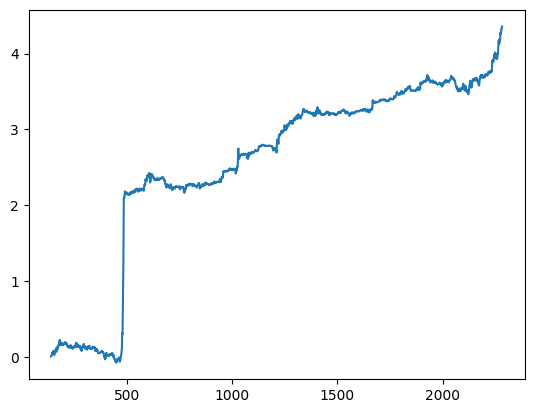

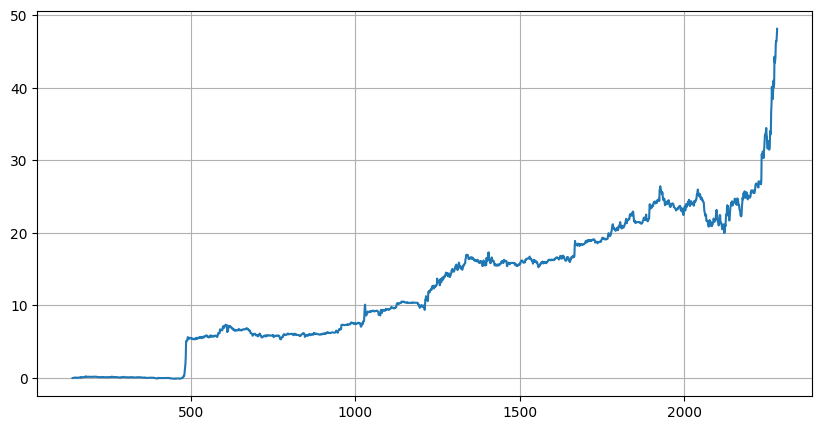

In [25]:
quantile = 35
fee_rate = 0.001
longshort_rets = quantile_longshort_returns(y, y_pred, np.ones(X.shape[0]), quantile, fee_rate)
display(longshort_rets.describe())
longshort_rets.cumsum().plot()
plt.show()
longshort_netval = longshort_rets.add(1).cumprod()
longshort_netval.sub(1).plot(figsize=(10, 5), grid=True)

longshort_rets_nofee = quantile_longshort_returns(y, y_pred, np.ones(X.shape[0]), quantile, 0)
longshort_netval_nofee = longshort_rets_nofee.add(1).cumprod()
# longshort_netval_nofee.sub(1).plot(figsize=(10, 5), grid=True)

grouped_returns, factor_quantiles = quantile_returns_and_groups(y, y_pred, quantile)
longshort_fee = calc_longshort_fee(factor_quantiles, quantile, fee_rate)
# display(longshort_fee.describe())
cumfee = longshort_netval_nofee.mul(longshort_fee).cumsum()
# display(cumfee)
# longshort_netval_nofee.sub(1).sub(cumfee).plot(grid=True)


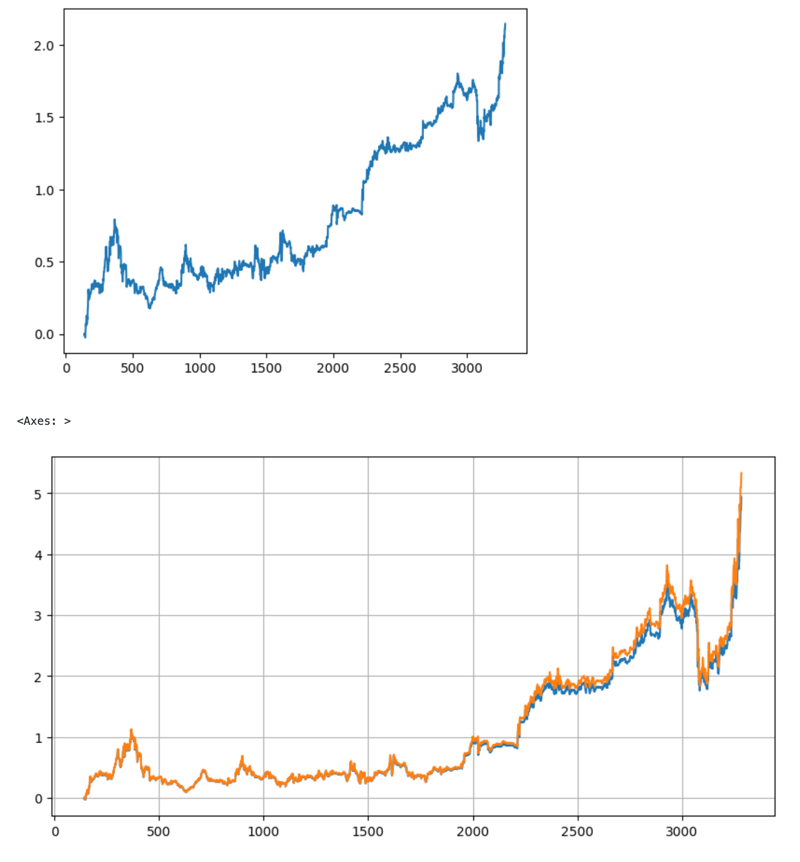

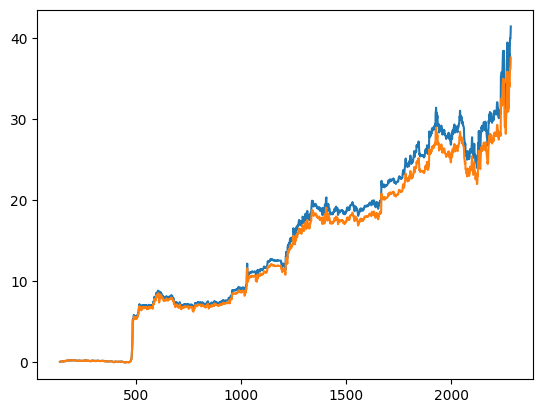

In [10]:
quantile = 35
fee_rate = 0.001

longshort_rets_nofee = quantile_longshort_returns(y, y_pred, np.ones(X.shape[0]), quantile, 0)
longshort_rets_nofee.add(1).cumprod().sub(1).plot()
longshort_netval_nofee = longshort_rets_nofee.add(1)

longshort_fee = calc_longshort_fee(factor_quantiles, quantile, fee_rate)
longshort_netval_fee = longshort_netval_nofee.mul(0.99).add(0.01 - 0.99 * longshort_fee).cumprod().sub(1)
# longshort_netval_fee = longshort_netval_nofee.mul(0.99).add(0.01).cumprod().sub(1)
longshort_netval_fee.plot()

longshort_netval_fee2 = longshort_rets_nofee.sub(longshort_fee).add(1).cumprod().sub(1)
# longshort_netval_fee2.plot()

,1,35,ls
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
2278,0.006564,0.074451,0.040507
2279,-0.007579,0.020605,0.006513
2280,0.014851,-0.016770,-0.000960
2281,0.040916,-0.012276,0.014320


,0,1,2,3,4,5,6,7,8,9,...,245,246,247,248,249,250,251,252,253,254
140,7,NaN,NaN,NaN,14,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,7,NaN,NaN,NaN,14,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,7,NaN,NaN,NaN,14,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,5,NaN,NaN,NaN,15,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144,5,NaN,NaN,NaN,15,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


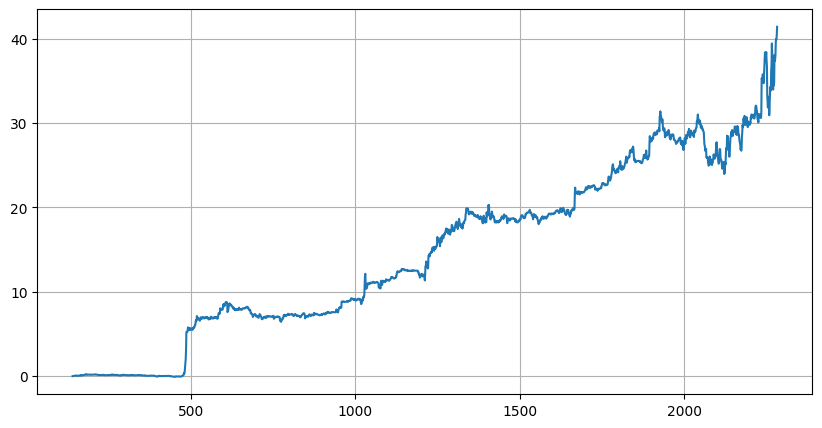

In [11]:
def compute_quantile_rets_2(y, y_pred, w, quantiles):
    y_pred = y_pred[w.astype(bool)]
    y = y[w.astype(bool)]
    if np.all(np.isnan(y_pred)):
        return None, None
    
    rets = pd.DataFrame(y)
    factor = pd.DataFrame(y_pred)

    ## use y (return) to mask y_pred to set 0 on all invaid cells to nan
    factor = factor.mask(rets.isna())
    
    groups = np.array(range(quantiles)) + 1
    
    try:
        factor_quantiles = (
            factor
            .rank(axis=1, method='first') # method first means assign different ranks on identical values
            .dropna(axis=0, how='all')
            .apply(pd.qcut, q=quantiles, labels=groups, axis=1, duplicates='drop')
        )
    except:
        print('here')
        return None, None
    
    stacked_rets = rets.stack()
    stacked_factor_quantiles = factor_quantiles.stack()
    grouped_returns = (
        stacked_rets
        .groupby([stacked_rets.index.get_level_values(0), stacked_factor_quantiles])
        .mean()
        .unstack()
        ) 
    return grouped_returns, factor_quantiles

grouped_returns, factor_quantiles = compute_quantile_rets_2(y, y_pred, np.ones(X.shape[0]), 35)
grouped_returns = grouped_returns[[1, 35]]
grouped_returns[1] = grouped_returns[1].mul(-1)
grouped_returns['ls'] = (grouped_returns[35] + grouped_returns[1]) / 2
display(grouped_returns)
grouped_returns.ls.add(1).cumprod().sub(1).plot(figsize=(10, 5), grid=True)
display(factor_quantiles)

In [12]:
grouped_returns

,1,35,ls
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
2278,0.006564,0.074451,0.040507
2279,-0.007579,0.020605,0.006513
2280,0.014851,-0.016770,-0.000960
2281,0.040916,-0.012276,0.014320


(9.873532655840785, 177.96894116187795, 0.5202986467568829)

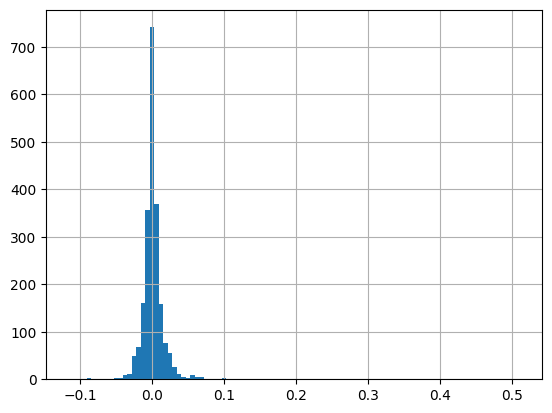

In [13]:
longshort_rets.hist(bins=100)
longshort_rets.skew(), longshort_rets.kurt(), longshort_rets[longshort_rets > 0].count() / longshort_rets.shape[0]

rolling_sharpe_sharpe: 4.047217796834827
slope: -0.0008653839390848609
radians: -0.0008653837230593493
degrees: -0.04958283499061877


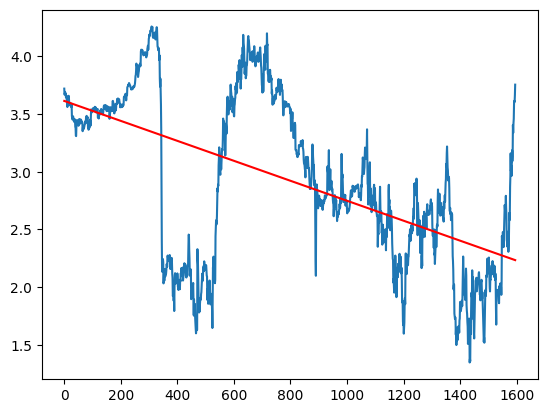

In [26]:
window = int(_annual_bar_8h/2)
rolling_sharpe = longshort_rets.rolling(window).mean() / longshort_rets.rolling(window).std() * np.sqrt(_annual_bar_8h)
rolling_sharpe = rolling_sharpe.dropna().reset_index(drop=True).iloc[-365*3*2:]
rolling_sharpe_sharpe_ = rolling_sharpe.mean() / rolling_sharpe.std()
print('rolling_sharpe_sharpe:', rolling_sharpe_sharpe_)

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
XX = rolling_sharpe.index.values.reshape(-1, 1)
model = lr.fit(XX, rolling_sharpe.values)
slope = model.coef_[0]
angle_radians = math.atan(slope)
angle_degrees = angle_radians * 180 / math.pi
print('slope:', slope)
print('radians:', angle_radians)
print('degrees:', angle_degrees)

rolling_sharpe.plot()
y_pred2 = model.predict(XX)
plt.plot(XX, y_pred2, color='red')
plt.show()

In [15]:
def calc_metrics(y, y_pred, w, metrics: list, quantile, fee_rate, annual_bars):
    ret = {}

    ## prepare data
    grouped_returns, factor_quantiles = quantile_returns_and_groups(y, y_pred, quantile)
    if grouped_returns.empty or factor_quantiles.empty or quantile not in grouped_returns.columns or 1 not in grouped_returns.columns:
        return pd.Series()
    longshort_rets = (grouped_returns[quantile] - grouped_returns[1]) / 2
    # long
    pfl = factor_quantiles[factor_quantiles == quantile]
    long_rates = turnover_rates(pfl)
    # short
    pfl = factor_quantiles[factor_quantiles == 1]
    short_rates = turnover_rates(pfl)
    longshort_rates = (long_rates + short_rates) / 2
    longshort_fee = longshort_rates * fee_rate
    longshort_rets_fee = longshort_rets - longshort_fee

    for metric in metrics:
        if metric == 'longshort_total_return_cumprod_with_fee':
            ret[metric] = total_return(longshort_rets_fee, comp=True)
        elif metric == 'longshort_total_return_cumsum_with_fee':
            ret[metric] = total_return(longshort_rets_fee, comp=False)
        elif metric == 'longshort_cagr_cumprod_with_fee':
            ret[metric] = cagr(longshort_rets_fee, comp=True, annual_bars=annual_bars)
        elif metric == 'longshort_cagr_cumsum_with_fee':
            ret[metric] = cagr(longshort_rets_fee, comp=False, annual_bars=annual_bars)
        elif metric == 'longshort_cagr_cumprod':
            ret[metric] = cagr(longshort_rets, comp=True, annual_bars=annual_bars)
        elif metric == 'longshort_cagr_cumsum':
            ret[metric] = cagr(longshort_rets, comp=False, annual_bars=annual_bars)
        elif metric == 'longshort_sharpe_fine_cumprod_with_fee':
            ret[metric] = sharpe_fine(longshort_rets_fee, comp=True, annual_bars=annual_bars)
        elif metric == 'longshort_sharpe_fine_cumsum_with_fee':
            ret[metric] = sharpe_fine(longshort_rets_fee, comp=False, annual_bars=annual_bars)
        elif metric == 'longshort_sharpe_simple_cumprod_with_fee':
            ret[metric] = sharpe_simple(longshort_rets_fee, annual_bars=annual_bars)
        elif metric == 'longshort_rolling_sharpe_sharpe_with_fee':
            ret[metric] = rolling_sharpe_sharpe(longshort_rets_fee, window=int(annual_bars/2), annual_bars=annual_bars)
        elif metric == 'longshort_cumprod_mdd_with_fee':
            ret[metric] = quantile_longshort_dd_top_n_mean(longshort_rets_fee, 1)
        elif metric == 'longshort_cumprod_top5_avg_mdd_with_fee':
            ret[metric] = quantile_longshort_dd_top_n_mean(longshort_rets_fee, 5)
        elif metric == 'longshort_sortino_cumprod_with_fee':
            ret[metric] = quantile_longshort_sortino(longshort_rets_fee, annual_bars=annual_bars)
        elif metric == 'longshort_winrate_with_fee':
            ret[metric] = win_rate(longshort_rets_fee)
        elif metric == 'monotonicity_with_fee':
            if len(grouped_returns) < 1:
                ret[metric] = _bad_fitness_val
            grouped_returns_mean = grouped_returns.mean()
            ranks = [sorted(grouped_returns_mean).index(x) + 1 for x in grouped_returns_mean]
            rank_differences = [ranks[i] - ranks[i-1] for i in range(1, len(ranks))]
            positive_differences = sum(1 for diff in rank_differences if diff > 0)
            negative_differences = sum(1 for diff in rank_differences if diff < 0)
            monotonicity_score = abs(positive_differences - negative_differences) / len(grouped_returns_mean) if len(grouped_returns_mean) > 0 else _bad_fitness_val
            ret[metric] = monotonicity_score
        elif metric == 'rank_ic':
            ret[metric] = ic(y, y_pred, w, rank_ic=True)
        elif metric == 'rank_icir':
            ret[metric] = icir(y, y_pred, w, rank_ic=True)
        elif metric == 'longshort_avg_turnover_rate':
            ret[metric] = longshort_rates.mean()
        else:
            print(f'  !! unknown metric {metric}, please check!')
            return pd.Series()
    ret = pd.Series(ret)
    ret.index.name = 'metric'
    ret.name = 'value'
    return ret


metrics = [
    'longshort_total_return_cumprod_with_fee', 
    'longshort_total_return_cumsum_with_fee',
    'longshort_cagr_cumprod_with_fee',
    'longshort_cagr_cumsum_with_fee',
    'longshort_cagr_cumprod',
    'longshort_cagr_cumsum',
    'longshort_sharpe_fine_cumprod_with_fee',
    'longshort_sharpe_fine_cumsum_with_fee',
    'longshort_sharpe_simple_cumprod_with_fee',
    'longshort_rolling_sharpe_sharpe_with_fee',
    'longshort_cumprod_mdd_with_fee',
    'longshort_cumprod_top5_avg_mdd_with_fee',
    'longshort_sortino_cumprod_with_fee',
    'longshort_winrate_with_fee',
    'monotonicity_with_fee',
    # 'rank_ic',
    # 'rank_icir',
    'longshort_avg_turnover_rate',

]
ret = calc_metrics(y, y_pred, np.ones(y.shape[0]), metrics, 35, fee_rate, _annual_bar_8h)
ret

metric
longshort_total_return_cumprod_with_fee     38.859321
longshort_total_return_cumsum_with_fee       4.165576
longshort_cagr_cumprod_with_fee              5.573797
longshort_cagr_cumsum_with_fee               2.129461
longshort_cagr_cumprod                       5.786811
longshort_cagr_cumsum                        2.160424
longshort_sharpe_fine_cumprod_with_fee       7.370851
longshort_sharpe_fine_cumsum_with_fee        2.816023
longshort_sharpe_simple_cumprod_with_fee     2.867237
longshort_rolling_sharpe_sharpe_with_fee     3.737174
longshort_cumprod_mdd_with_fee              -0.263578
longshort_cumprod_top5_avg_mdd_with_fee     -0.261250
longshort_sortino_cumprod_with_fee           6.593933
longshort_winrate_with_fee                   0.520542
monotonicity_with_fee                        0.171429
longshort_avg_turnover_rate                  0.031046
Name: value, dtype: float64

In [16]:
%timeit calc_metrics(y, y_pred, np.ones(y.shape[0]), metrics, 35, fee_rate, annual_bar_8h)

501 ms ± 85.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
import pandas as pd

series1 = pd.Series([1, 2, 3])
series2 = pd.Series([4, 5, 6])

merged_series = pd.concat([series1, series2], axis=0)
merged_series

0    1
1    2
2    3
0    4
1    5
2    6
dtype: int64

In [18]:
exp = 'netbuyquo3'
gp = convert_expression_to_gp_program(exp, _all_func_dictionary, feature_names)
print(f'_Program print: {gp}')
y_pred1 = pd.DataFrame(gp.execute_3D(X))

# exp = 'sub(ts_min_10(TZS60_spot_Close), premIdx_close)'
# exp = 'min(NETBUYQUO1_EMA_10, ts_min_10(TZS60_HL2))'
exp = 'sub(ts_min_5(TZS60_SPOT_DEMA_10), TZS60_SPOTTAKERBUYVOL_PWMA_10)'
gp = convert_expression_to_gp_program(exp, _all_func_dictionary, feature_names)
print(f'_Program print: {gp}')
y_pred2 = pd.DataFrame(gp.execute_3D(X))

# display(y_pred1)
# display(y_pred2)

y_pred1.corrwith(y_pred2, axis=1).mean()


_Program print: netbuyquo3
_Program print: sub(ts_min_5(TZS60_SPOT_DEMA_10), TZS60_SPOTTAKERBUYVOL_PWMA_10)


-0.0044787347053078085

In [19]:
%timeit y_pred1.corrwith(y_pred2, axis=1).mean()

36.5 ms ± 6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
10000*9999 / 2 * 0.012/3600/20

8.3325